In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# https://colab.research.google.com/drive/1AZNRYC07jTNEcgbG9-lTmKbnqORy2P7f#scrollTo=28kaD_-ZjzPH

In [3]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
# https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomCrop(448, pad_if_needed=True, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomCrop(448, pad_if_needed=True, padding_mode='reflect'),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['cat', 'dog']

In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

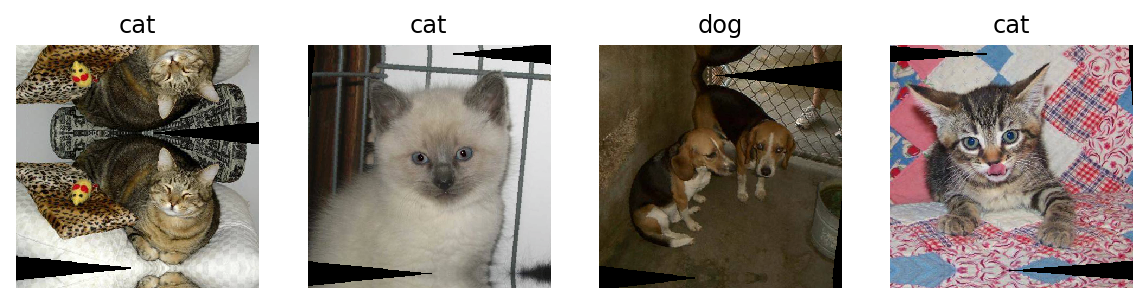

In [4]:
# train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(classes[labels[ii]])

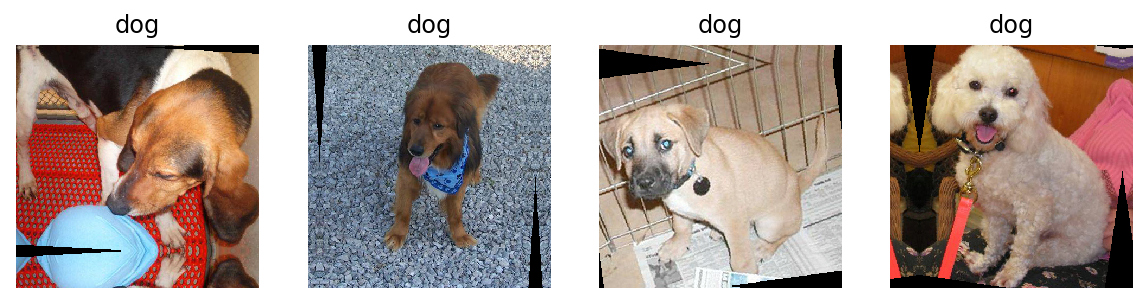

In [6]:
# valid_loader 
data_iter = iter(valid_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(classes[labels[ii]])

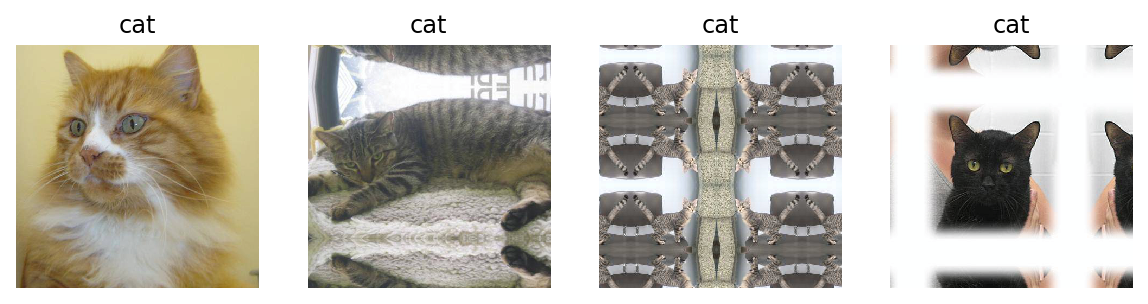

In [6]:
# test_loader 
data_iter = iter(test_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(classes[labels[ii]])

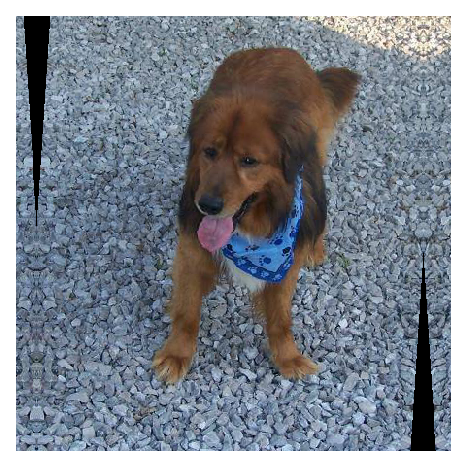

In [26]:
imshow(images[1])

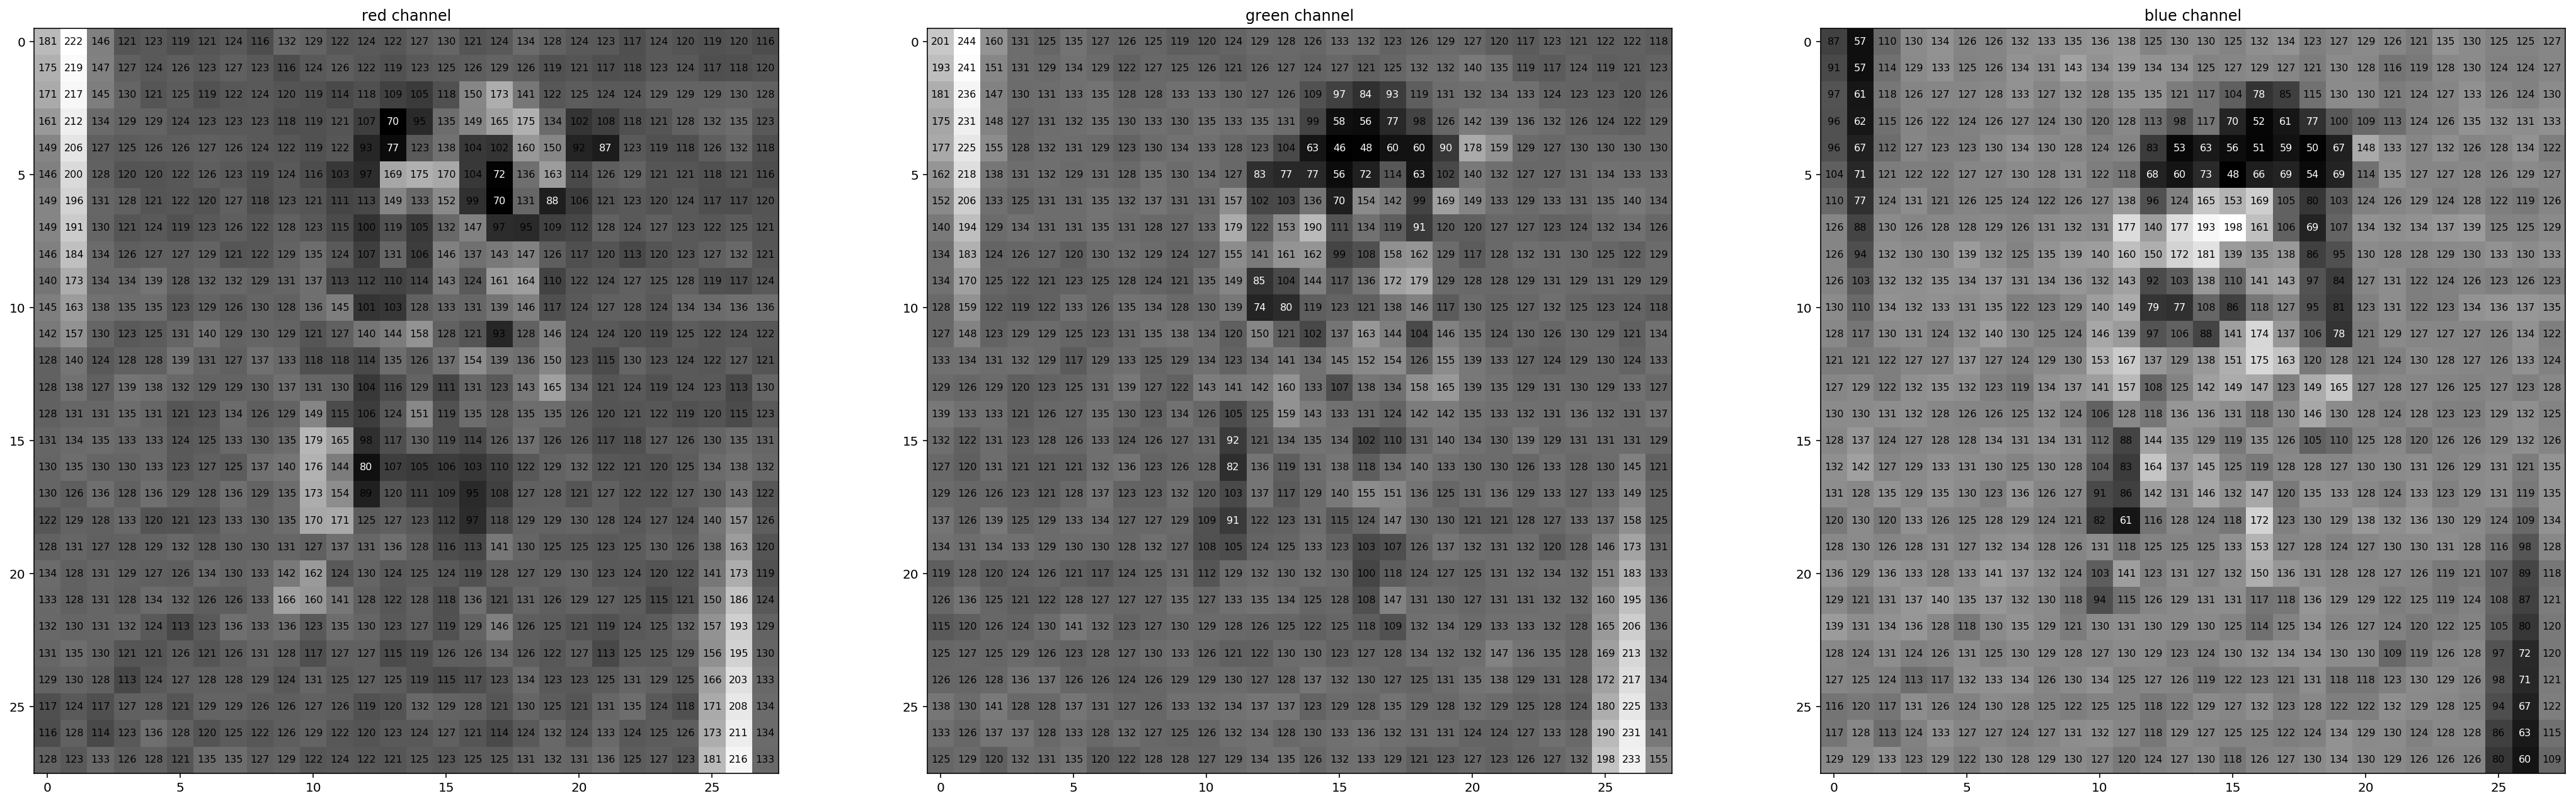

In [24]:
# run only with small images, e.g. 28*28 (cifar-10, MNIST)
# do NOT run otherwise, it is just meant to provide an intuition 
# https://discuss.pytorch.org/t/applying-transforms-to-a-single-image/56254
# https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image

trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize(28)])
rgb_img = np.array(trans(images[1]))
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[2]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[:,:,idx] # to get each of the channels
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y] < thresh else 'black')

In [27]:
# https://pytorch.org/docs/stable/torchvision/models.html?highlight=models
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# freeze the current model 
for param in model.parameters():
    param.requires_grad = False

In [29]:
# original fc must be replaced - new head
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [30]:
from collections import OrderedDict
head = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 512)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(512, 128)),
                          ('relu3', nn.ReLU()),
                          ('fc4', nn.Linear(128, 32)),
                          ('relu4', nn.ReLU()),
                          ('fc5', nn.Linear(32, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [31]:
# full list retrievable by model.state_dict().keys()
model.fc = head

In [34]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [36]:
criterion = nn.NLLLoss()
# Only train the head parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [10]:
print(len(train_loader))
len(train_loader.sampler)

282


18000

In [11]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

if train_on_gpu:
    model = model.cuda()

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler) # returns the number of images in the train_loader
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    train_losses.append(train_loss)  
    valid_losses.append(valid_loss)    
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cats_dogs.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.116890 	Validation Loss: 0.042842
Validation loss decreased (inf --> 0.042842).  Saving model ...
Epoch: 2 	Training Loss: 0.058193 	Validation Loss: 0.153460
Epoch: 3 	Training Loss: 0.062834 	Validation Loss: 0.052302
Epoch: 4 	Training Loss: 0.068728 	Validation Loss: 0.088234
Epoch: 5 	Training Loss: 0.062608 	Validation Loss: 0.047218
Epoch: 6 	Training Loss: 0.053194 	Validation Loss: 0.036432
Validation loss decreased (0.042842 --> 0.036432).  Saving model ...
Epoch: 7 	Training Loss: 0.050097 	Validation Loss: 0.041695
Epoch: 8 	Training Loss: 0.052007 	Validation Loss: 0.032263
Validation loss decreased (0.036432 --> 0.032263).  Saving model ...
Epoch: 9 	Training Loss: 0.052376 	Validation Loss: 0.055110
Epoch: 10 	Training Loss: 0.054971 	Validation Loss: 0.034020


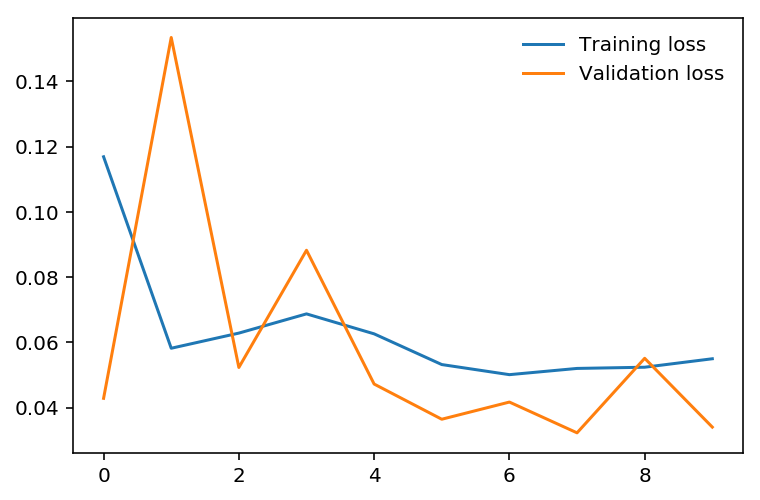

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [32]:
# load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('model_cats_dogs.pt'))

<All keys matched successfully>

### Evaluate Trained Model on Test Set

In [37]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

if train_on_gpu:
    model = model.cuda()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    # compare predictions to true label
    correct_tensor = top_class.eq(target.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(correct.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.030702

Test Accuracy of   cat: 98% (1234/1250)
Test Accuracy of   dog: 99% (1240/1250)

Test Accuracy (Overall): 98% (2474/2500)


In [ ]:
# awesome!